In [10]:
import pandas as pd

In [11]:
#goodreads reviews shared

sh_good_EN=pd.read_csv("C:\\Users\\Fossati\\Desktop\\Tesi\\Dati\\Dati_SharedBooks\\Inglese\\Goodreads_shared_reviews.csv")
sh_good_EN.columns

Index(['Unnamed: 0', 'Titolo', 'ISBN', 'Genere', 'Shelves', 'N_Likes_GR',
       'Userlist_GR', 'Rating_GR', 'Rev_Date_GR', 'Rev_Content_GR'],
      dtype='object')

In [12]:
#amazonEN reviews shared

sh_ama_EN=pd.read_csv("C:\\Users\\Fossati\\Desktop\\Tesi\\Dati\\Dati_SharedBooks\\Inglese\\AmazonEN_shared_reviews.csv")
sh_ama_EN.columns

Index(['Unnamed: 0', 'Title', 'ISBN', 'Genere', 'Username', 'Stars', 'Date',
       'ReviewCountry', 'N_Likes', 'Content'],
      dtype='object')

In [13]:
#goodreads en

ama_EN=pd.read_csv("C:\\Users\\Fossati\\Desktop\\Tesi\\Dati\\Dati_English\\Amazon_EN\\Amazon_Reviews_EN_to300.csv")
ama_EN.columns

Index(['Unnamed: 0', 'Title', 'ISBN', 'Genere', 'Username', 'Stars', 'Date',
       'ReviewCountry', 'N_Likes', 'Content', 'Language_AZ'],
      dtype='object')

In [14]:
gr_EN=pd.read_csv("C:\\Users\\Fossati\\Desktop\\Tesi\\Dati\\Dati_English\\Goodreads_EN\\Goodreads_Reviews_EN.csv")
gr_EN.columns

Index(['Unnamed: 0', 'Genere', 'Titolo', 'ISBN', 'Rev_Date_GR', 'Rating_GR',
       'Userlist_GR', 'N_Likes_GR', 'Shelves', 'Rev_Content_GR',
       'Language_GR'],
      dtype='object')

In [58]:
#in questo foglio effettuiamo prove per capire come sfruttare la funzione predict al fine di passare grande mole di dati al BERT

In [59]:
#inoltre creiamo funzioni e facciamo prime prove di testing del modello annotato inglese

In [16]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast
from transformers import Trainer, TrainingArguments
# For data manipulation and analysis
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import torch


In [37]:
def prediction_test_nolabels(dataset,colname):  #dataset fa riferimento al set di dati che vogliamo passare, modello dipende dal tipo di FT
#poi ci sarà anche la funzione per predire senza labels
  from IPython.utils import io
  with io.capture_output() as captured: #non vogliamo i print che intasano la ram
  
  #print("This wont print")
    tok = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')
    mod = XLMRobertaForSequenceClassification.from_pretrained('Polarity_fin_xlmr') #modello migliore ottenuto
   
    unique_labels={'Neutra', 'Positiva', 'Negativa'}
    label2id={'Negativa': 2, 'Neutra': 0, 'Positiva': 1}
    id2label={2:'Negativa', 0:'Neutra', 1:'Positiva'}
    
    training_args = TrainingArguments(
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    learning_rate=2e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=2000,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',
    save_strategy='no'# evaluate during fine-tuning so that we can see progress 
    )
    
    class MyDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels) 
    
    #test_texts=dataset[colname] #sentence
    
    #da qui parte il codice
    frasi=dataset[colname].tolist()
     
    prediction=[]  #lista che sarà riempita con le predizioni
    score=[]#lista che sarà riempita con gli punt
    #entrambe saranno incollate ai dataset alla fine
    to_drop=['',' ','.',',','!']
    count=0
    print_c=[15000, 50000, 100000, 150000, 200000, 250000]
    frasi_pred=[]
    for el in frasi:
        count+=1
        punt=0
        spl=el.replace("!","!.").replace("?","?.").replace("|",".").split(".")#e ottengo una lista di stringhe
        
        test_texts=[] #lista frasi pulite
        for stringa in spl:
            if stringa not in to_drop:
                test_texts.append(stringa)
            
        test_labels=['Neutra'] * len(test_texts)  #lista casuale con labels, per non cambiare la struttura del codice al fine di poterlo usare anche senza labels per fare testing

        test_encodings  = tok(test_texts, truncation=True, padding=True, max_length=128) #, return_tensors='pt'
        test_labels_encoded  = [label2id[y] for y in test_labels]

        test_dataset = MyDataset(test_encodings, test_labels_encoded)
        

        trainer = Trainer(model=mod, args=training_args)  #basta avere il modello come parametro

        predicted_results=trainer.predict(test_dataset)
    
        predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
        predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
        predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability
        
        for pred in predicted_labels: 
            frasi_pred.append(pred)
            if pred == 'Neutra':
                punt+=0
            elif pred == 'Positiva':
                punt+=2.5
            elif pred == 'Negativa':
                punt+=-2.5
        
        try:
            punteggio=round(float(punt/len(predicted_labels)),2)
            score.append(punteggio) #appendiamo risultato alla lista score
        except:
            score.append('error')
            prediction.append('Neutra')
        
        if punteggio <= -1.5:
            prediction.append('Fortemente_Negativa')
        elif punteggio >= 1.5:
            prediction.append('Fortemente_Positiva')
        elif punteggio < 1.5 and punteggio > 0.5:
            prediction.append('Positiva')
        elif punteggio > -1.5 and punteggio < -0.5:
            prediction.append('Negativa')
        else:
            prediction.append('Neutra')
            
        if count in print_c:
            print(count)
        


    return prediction, score, frasi_pred

In [ ]:
#prova con set ampio di recensioni

In [ ]:
#prova finalizzata a capure un po' come funziona il modello, se ha senso e se bisogna ca,biare le soglie

In [ ]:
sh_gr=prediction_test_nolabels(sh_good_EN.sample(5000),'Rev_Content_GR')  #variabilizza o sei finito
#sh_good_EN['Sentiment']=sh_gr

In [ ]:
sh_am=prediction_test_nolabels(sh_ama_EN.sample(5000),'Content')  #variabilizza o sei finito
#sh_good_EN['Sentiment']=sh_gr

In [69]:
import numpy as np
print(np.mean(sh_gr[1]))
print(np.median(sh_gr[1]))
print(np.std(sh_gr[1]))

1.268836
1.25
1.2308682430588038


In [ ]:
#media abbastanza vicina a mediana, popolazione approssimabile a normale
#media estremamente positiva, dato riscontrato anche dal rating statistiche

In [70]:
import numpy as np
print(np.mean(sh_am[1]))
print(np.median(sh_am[1]))
print(np.std(sh_am[1]))

1.4405873333333332
1.67
1.222496143841044


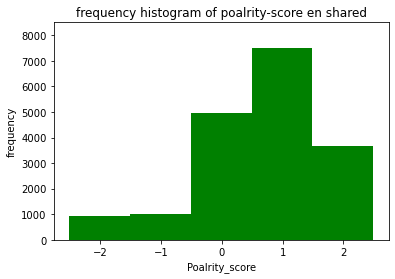

In [75]:
#normalità della distribuzione?

import matplotlib.pyplot as plt

bins=np.arange(-2.51,2.51, 1) 
#min = 3.45
#max= 4.9

        
plt.hist(sh_am[1]+sh_gr[1], bins, color='green')
plt.ylabel('frequency')
plt.xlabel('Poalrity_score')
plt.ylim((0,8500))
plt.title('frequency histogram of polarity-score en shared')
plt.show()

# si puo' assumere normalita'
    

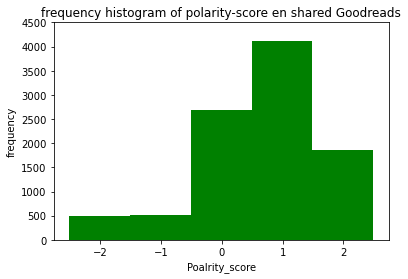

In [80]:
#normalità della distribuzione?

import matplotlib.pyplot as plt

bins=np.arange(-2.51,2.51, 1) 
#min = 3.45
#max= 4.9

        
plt.hist(sh_gr[1], bins, color='green')
plt.ylabel('frequency')
plt.xlabel('Poalrity_score')
plt.ylim((0,4500))
plt.title('frequency histogram of polarity-score en shared Goodreads')
plt.show()

# si puo' assumere normalita'
    

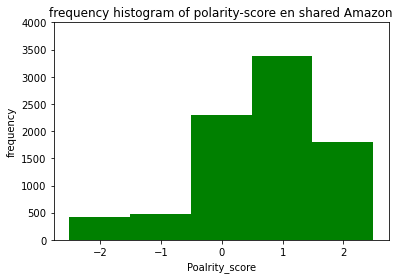

In [79]:
#normalità della distribuzione?

import matplotlib.pyplot as plt

bins=np.arange(-2.51,2.51, 1) 
#min = 3.45
#max= 4.9

        
plt.hist(sh_am[1], bins, color='green')
plt.ylabel('frequency')
plt.xlabel('Poalrity_score')
plt.ylim((0,4000))
plt.title('frequency histogram of polarity-score en shared Amazon')
plt.show()

# si puo' assumere normalita'
    

In [81]:
neg=0
neu=0
pos=0
for pred in sh_am[0]+sh_gr[0]:
    if pred=='Neutra':
        neu+=1
    elif pred=='Positiva':
        pos+=1
    else:
        neg+=1
print(neu)
print(pos)
print(neg)

5358
7128
17514


In [82]:
pd.DataFrame(sh_am[0]+sh_gr[0]).groupby(0).size()

0
Fortemente_Negativa      935
Fortemente_Positiva    15598
Negativa                 981
Neutra                  5358
Positiva                7128
dtype: int64

In [ ]:
#sbilanciamento netto a favore delle recensioni positive, e stando ai rating ha senso la cosa

In [ ]:
#prova per frasi singole

In [83]:
pd.DataFrame(sh_am[2]+sh_gr[2]).groupby(0).size()

0
Negativa    22589
Neutra      40254
Positiva    80059
dtype: int64

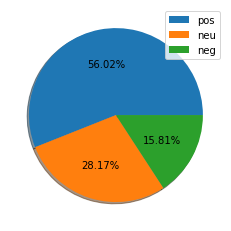

In [84]:
import matplotlib.pyplot as plt
import numpy as np
def pie(lista):
    y = np.array(lista)
    mylabels = ["pos","neu","neg"]
    plt.pie(y, shadow = True,autopct='%.2f%%')#labels= percent
    plt.legend(mylabels,loc="upper right")
    return plt.show() 
pie([80059, 40254, 22589])

In [ ]:
#adesso si fa sul serio

In [ ]:
sh_gr=prediction_test_nolabels(sh_good_EN,'Rev_Content_GR')  
print(len(sh_gr[0]))
print(len(sh_gr[1]))

In [47]:
sh_good_EN['Sentiment']=sh_gr[0]
sh_good_EN['Sent_Score']=sh_gr[1]
sh_ama_EN.to_csv('Goodreads_shared_reviews.csv')

In [45]:
pd.DataFrame(sh_gr[0]).groupby(0).size()

0
Fortemente_Negativa    1210
Fortemente_Positiva    9495
Negativa               1166
Neutra                 4402
Positiva               4744
dtype: int64

In [ ]:
#ok

In [ ]:
sh_am=prediction_test_nolabels(sh_ama_EN,'Content')  


In [46]:
print(len(sh_am[0]))
print(len(sh_am[1]))
pd.DataFrame(sh_am[0]).groupby(0).size()

47337
47337


0
Fortemente_Negativa     2107
Fortemente_Positiva    27964
Negativa                2073
Neutra                  6749
Positiva                8444
dtype: int64

In [48]:
sh_ama_EN['Sentiment']=sh_am[0]
sh_ama_EN['Sent_Score']=sh_am[1]
sh_ama_EN.to_csv('AmazonEN_shared_reviews.csv')

In [ ]:
gr=prediction_test_nolabels(gr_EN,'Rev_Content_GR')  
print(len(gr[0]))
print(len(gr[1]))


In [51]:
pd.DataFrame(gr[0]).groupby(0).size()

0
Fortemente_Negativa     13409
Fortemente_Positiva    109244
Negativa                14921
Neutra                  52262
Positiva                57628
dtype: int64

In [52]:
gr_EN['Sentiment']=gr[0]
gr_EN['Sent_Score']=gr[1]
gr_EN.to_csv('Goodreads_Reviews_EN.csv')

In [ ]:
ama=prediction_test_nolabels(ama_EN,'Content')  
print(len(ama[0]))
print(len(ama[1]))



In [54]:
pd.DataFrame(ama[0]).groupby(0).size()

0
Fortemente_Negativa     11798
Fortemente_Positiva    175250
Negativa                10478
Neutra                  30802
Positiva                41573
dtype: int64

In [55]:
ama_EN['Sentiment']=ama[0]
ama_EN['Sent_Score']=ama[1]
ama_EN.to_csv('Amazon_Reviews_EN_to300.csv')